In [32]:
import trimesh
import xatlas
import torch

torch.set_grad_enabled(False)

uids = {
    "owl": "f98c5ee54c4a48f8b5eafd35a81dde4d",
    "helmet": "a8813ea1e0ce47ab97a416637a7520d7",
    "backpack": "9fa2da2c42234b58896e8d23393cac24",
    "penguin": "b19ef2650b4347348710eb6364ca90bd",
    "armor": "8a60954eccad433e987bbcafc7657140",
    'lion': 'fadefc1eee3246a189f6b79c7c671343'
}

In [33]:
import objaverse

objects = objaverse.load_objects(uids.values())
metadata = objaverse.load_annotations(uids.values())

In [34]:
key = 'helmet'

uid = uids[key]
name = metadata[uid]['name']
path = objects[uid]
mesh = trimesh.load_mesh(path)

In [35]:
from pathlib import Path
from matplotlib import pyplot as plt

mesh = trimesh.load_mesh(path)

obj_path = Path("data/meshes") / f'{key}.obj'

vmapping, indices, uvs = xatlas.parametrize(mesh.vertices, mesh.faces)
xatlas.export(str(obj_path), mesh.vertices[vmapping], indices, uvs)

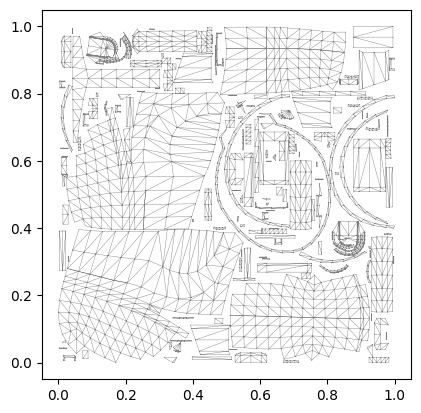

In [37]:
import torch
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.util import read_obj_with_uvs

from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.matplotlib_utils import mpl_uv_triangulation
from pytorch3d.renderer import FoVPerspectiveCameras

from text3d2video.utilities.video_comparison import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

mesh, verts_uvs, faces_uvs = read_obj_with_uvs(obj_path)

fig, ax = plt.subplots()
ax.triplot(mpl_uv_triangulation(verts_uvs, faces_uvs), lw=0.3, color="black", alpha=0.5)
ax.set_aspect("equal")

dist = 2
elev = 0
fov = 30
angles = torch.linspace(0, 360, 20)
R, T = turntable_extrinsics(dists=dist, angles=angles, elevs=elev)
cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=fov)
meshes = mesh.extend(len(cams))

display_vid(pil_frames_to_clip(render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs)))